# LAB 3: Grafos de conocimiento
#### (y algo de NLP)


**Ingeniería Electrónica**

**Inteligencia Artificial**

**12/04/2022**

El grafo de conocimiento es un concepto fascinante de la ciencia de datos. Es un método de representación del conocimiento mediante entidades interconectadas que pueden ser personas, ubicaciones, eventos, organizaciones, etc. 

Para construir un grafo de conocimiento, necesitamos formar **triples:sujeto, predicado y objeto** (o *entitad-propiedad-valor*) para vincular datos utilizando ontologías y semántica. 

En esta práctica, se utilizará una popular librería de Python para el procesamiento avanzado de lenguaje natural, [spaCy](https://spacy.io/usage).

## Librerías adicionales

⚠️ Ejecutar los siguientes comandos en la terminal para instalar las librerías necesarias:

   * conda install -c conda-forge spacy
   * python -m spacy download en_core_web_sm  (*procesamiento para idioma __inglés__*)
   * python -m spacy download es_core_news_sm  (*procesamiento para idioma __español__*)
   * conda install -c anaconda networkx (puede estar ya incluido en anaconda)

In [1]:
import spacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

Revisa la documentación de estas librerías para conocer sus funcionalidades.

## Visualizar entidades y relaciones

El procesamiento de texto con `nlp` devuelve un objeto `Doc` que contiene toda la información sobre los *tokens*, sus características lingüísticas y sus relaciones.

In [2]:
nlp = spacy.load('es_core_news_sm') # para procesamiento de textos en español

doc = nlp("El tipo lanzó el ladrillo")

for tok in doc:
  print(tok.text, "...", tok.dep_)

El ... det
tipo ... nsubj
lanzó ... ROOT
el ... det
ladrillo ... obj


Para visualizar en un cuaderno de Jupyter, se usa `displacy.render`.

In [3]:
displacy.render(doc, style="dep")

In [4]:
nlp = spacy.load('en_core_web_sm') # para procesamiento de textos en inglés

doc = nlp("If your hate could be turned into electricity, it would light up the whole world.")

for tok in doc:
  print(tok.text, "-->", tok.dep_)

If --> mark
your --> poss
hate --> nsubjpass
could --> aux
be --> auxpass
turned --> advcl
into --> prep
electricity --> pobj
, --> punct
it --> nsubj
would --> aux
light --> ROOT
up --> prt
the --> det
whole --> amod
world --> dobj
. --> punct


In [5]:
displacy.render(doc, style="dep")

In [6]:
nlp = spacy.load('es_core_news_sm')

doc = nlp("La imagen del agujero negro fue renderizada por la joven ingeniera.")

for tok in doc:
  print(tok.text, "-->", tok.dep_)

La --> det
imagen --> nsubj
del --> case
agujero --> nmod
negro --> amod
fue --> aux
renderizada --> ROOT
por --> case
la --> det
joven --> obj
ingeniera --> advcl
. --> punct


In [7]:
displacy.render(doc, style="dep")

## Construir un grafo de conocimiento a partir de datos de texto

Lo construiremos en base un conjunto de datos, oraciones compiladas de artículos de wikipedia relacionados con la producción de cine. El archivo CSV de ejemplo está incluido en la carpeta de la práctica como "wiki_sentences.csv". Éstas oraciones están en inglés por lo que se debe cargar el modelo correspondente.

In [8]:
nlp = spacy.load('en_core_web_sm')

### Leer Datos desde CSV

In [9]:
# importar archivo con oraciones de wikipedia utilizando pandas (pd)
sentencias_candidatas = pd.read_csv("wiki_sentences.csv")
sentencias_candidatas.shape

(4318, 1)

In [10]:
# Realizar una muestra de 5 oraciones
sentencias_candidatas['sentence'].sample(5)

3838    however the absence of bhaskar and mani sharma...
3197        various iranian officials condemned the film.
190                           they jumped to conclusions.
1826                   some authors resisted these terms.
2395    until 1947 malayalam films were made by tamil ...
Name: sentence, dtype: object

In [11]:
doc = nlp("jim carrey also auditioned for the role")

for tok in doc:
  print(tok.text, "-->", tok.dep_)

jim --> compound
carrey --> nsubj
also --> advmod
auditioned --> ROOT
for --> prep
the --> det
role --> pobj


### Extracción de pares de entidades

Se pretende analizar una oración para extraer el sujeto y el objeto (las entidades) a medida que es leída. Sin embargo, existen algunos desafíos: una entidad puede abarcar varias palabras, y los analizadores de dependencia etiquetan solo las palabras individuales como sujetos u objetos.

La siguiente función extrae las entidades de una oración tomando en cuenta los problemas mencionados.

**Parte 1**
En la primera porción de código, se han definifo variables vacías. **prv_tok_dep** y **prv_tok_text** contendrán la etiqueta de dependencia de la palabra anterior en la oración y la palabra anterior en sí, respectivamente. **prefix** y **modifier** contendrán el texto asociado con el sujeto o el objeto.

**Parte 2**
A continuación, recorreremos los tokens en la oración. Primero verificaremos si el token es un signo de puntuación o no. En caso de serlo, lo ignoraremos y pasaremos al siguiente token. Si el token es parte de una palabra compuesta (etiqueta de dependencia = "*compound*"), lo mantendremos en la variable *prefix*. Una palabra compuesta es una combinación de varias palabras vinculadas para formar una palabra con un nuevo significado (ejemplo: "pista de patinaje", "amante de los libros").

**Parte 3**
Si el token es el sujeto, se capturará como la primera entidad en la variable **ent1**. Las variables prefix, modifier, prv_tok_dep y prv_tok_text se restablecen.

**Parte 4**
Si el token es el objeto, se capturará como la segunda entidad en la variable **ent2**. Las variables prefix, modifier, prv_tok_dep y prv_tok_text se restablecen.

**Parte 5**
Una vez que se haya capturado el sujeto y el objeto en la oración, actualizaremos el token anterior y su etiqueta de dependencia.

In [12]:
def get_entities(sent):
  ## Parte 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # etiqueta de dependencia del token anterior en la oración
  prv_tok_text = ""   # token anterior en la oración

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## Parte 2
    # Si el token es un signo de puntuación, pase al siguiente token
    if tok.dep_ != "punct":
      # comprobar: token es una palabra compuesta o no
      if tok.dep_ == "compound":
        prefix = tok.text
        # si la palabra anterior también era un 'compound', entonces agregar la palabra actual
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # comprobar: el token es un modificador o no
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # si la palabra anterior también era un 'compound', entonces agregar la palabra actual
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## Parte 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## Parte 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## Parte 5 
      # actualizar variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

Probamos esta función en una oración:

In [13]:
get_entities("An electric motor uses electrical energy")

['electric  motor', 'electrical  energy']

En la oración anterior, "*electric  motor*" es el sujeto y "*electrical energy*" es el objeto.

Ahora podemos usar esta función para extraer estos pares de entidades para todas las oraciones en nuestros datos:

In [14]:
pares_entidades = []

for i in tqdm(sentencias_candidatas["sentence"][0:200]): # con tqdm podemos mostrar una barra de progreso
  pares_entidades.append(get_entities(i))

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 209.68it/s]


La lista **pares_entidades** contiene todos los pares sujeto-objeto de las oraciones del archivo csv. Revisemos a algunos de ellos:

In [15]:
pares_entidades[10:20]

[['we', 'tests'],
 ['', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'eberhardt portrays'],
 ['singer', 'men']]

###  Extracción de relaciones / predicados

El predicado puede ser el verbo principal de una oración. La siguiente función utiliza la concordancia basada en reglas de spaCy para encontrar dichos predicados:

In [16]:
def get_relation(sent):

  doc = nlp(sent)

  # objeto de la clase Matcher
  matcher = Matcher(nlp.vocab)

  # definir el patrón 
  pattern = [[{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}]] 
    
  matcher.add("matching_1", pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

El patrón definido en la función intenta encontrar la palabra raíz (ROOT) o el verbo principal en la oración. Una vez que se identifica el ROOT, el patrón verifica si es seguido por una preposición ("prep") o una palabra de agente. De ser así, se agrega a la palabra ROOT.

In [17]:
get_relation("An ECG detects the heartbeats.")

'detects'

Del mismo modo, se pueden obtener las relaciones de todas nuestras oraciones:

In [18]:
relaciones = []
for i in tqdm(sentencias_candidatas["sentence"][0:200]): # con tqdm podemos mostrar una barra de progreso
  relaciones.append(get_relation(i))

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 226.46it/s]


Revisamos a las relaciones o predicados más frecuentes que se acaban de extraer:

In [19]:
pd.Series(relaciones).value_counts()[:20]

is                13
scheduled          8
released           7
include            5
was                4
expected           4
revealed           3
introduced in      2
brought            2
drafted by         2
cast in            2
begun by early     2
announced at       2
affleck as         2
began in           2
announced in       2
confirmed as       2
began on           2
reported           2
became             2
dtype: int64

Resulta que relaciones como "A es B" y "A era B" son las relaciones más comunes.

### Construir un grafo de conocimiento

Finalmente crearemos un grafoo de conocimiento a partir de las entidades extraídas (pares sujeto-objeto) y los predicados (relación entre entidades). Creamos un dataframe de entidades y predicados:

In [20]:
# extraer sujeto
fuente = [i[0] for i in pares_entidades]

# extraer objeto
objetivo = [i[1] for i in pares_entidades]

gc_df = pd.DataFrame({'fuente':fuente, 'objetivo':objetivo, 'arista':relaciones})

In [21]:
gc_df

,fuente,objetivo,arista
0,connie,own,decides
1,later scream,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,,outside cult him,wails with
...,...,...,...
195,trick films,special effects,were silent
196,l'inferno,three artists,directed by
197,series,close surrealist movement,is
198,film,five stories,split into


A continuación, utilizaremos la librería **networkx** para crear una red a partir de este dataframe. Los nodos representarán las entidades y las aristas o conexiones entre los nodos representarán las relaciones entre los nodos.

Será un grafo dirigido. En otras palabras, la relación entre cualquier par de nodos conectados no es bidireccional, es solo de un nodo a otro.

In [22]:
# crear un grafo dirigido desde un dataframe
G=nx.from_pandas_edgelist(gc_df, "fuente", "objetivo", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

Graficamos la red (esto puede tardar unos minutos):

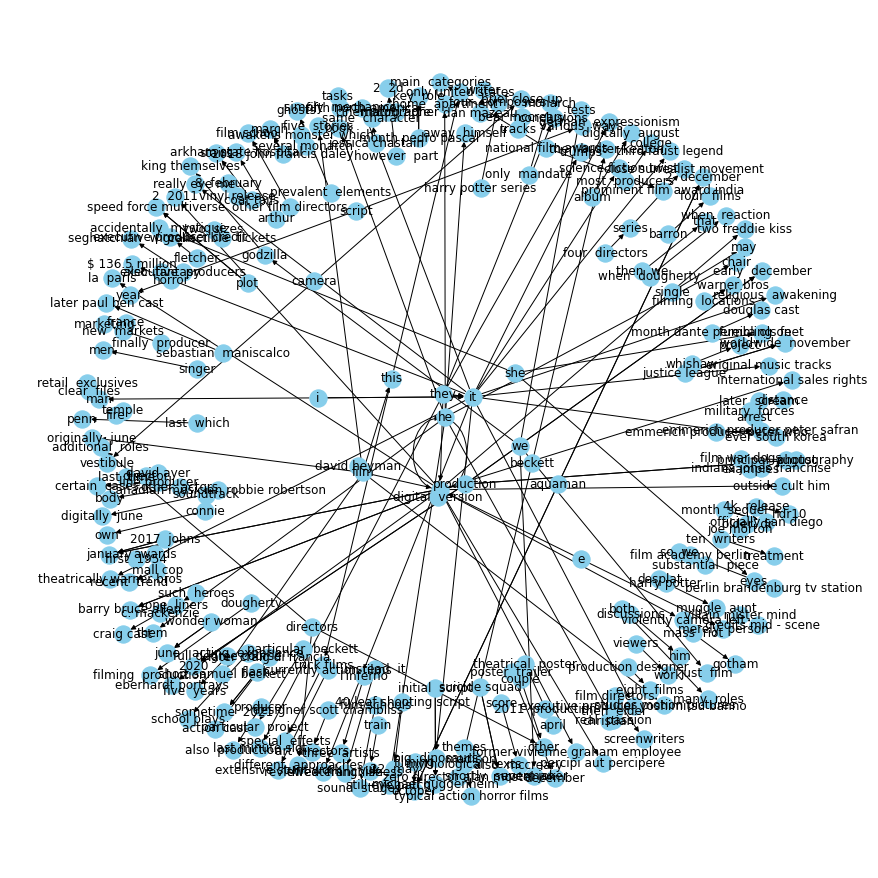

In [23]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Resulta que hemos creado un gráfico con todas las relaciones que teníamos. Se vuelve realmente difícil visualizar un gráfico con muchas relaciones o predicados.

Por lo tanto, es recomendable utilizar solo unas pocas relaciones importantes para visualizar un gráfico, tomando una relación a la vez. Por ejemplo, con la relación "composed by":

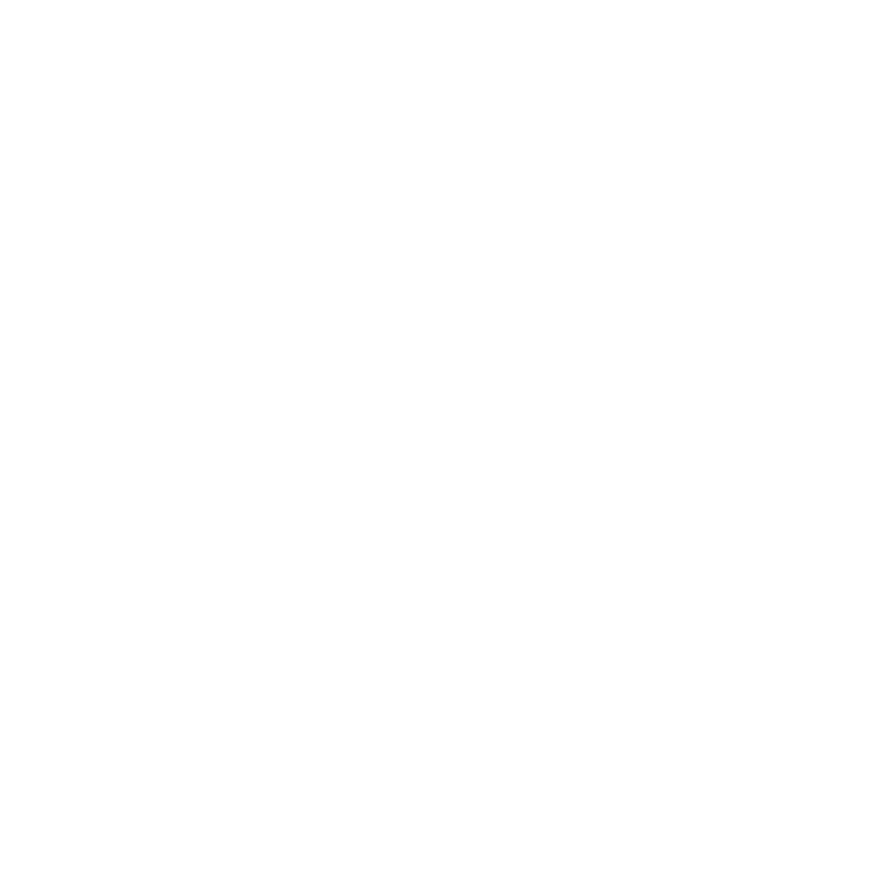

In [24]:
G=nx.from_pandas_edgelist(gc_df[gc_df['arista']=="composed by"], "fuente", "objetivo", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regula la distancia entre nodos
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Esa es una gráfica mucho más legible. Aquí las flechas apuntan hacia los compositores. Veamos algunas relaciones más. Qué se puede notar en los resultados?

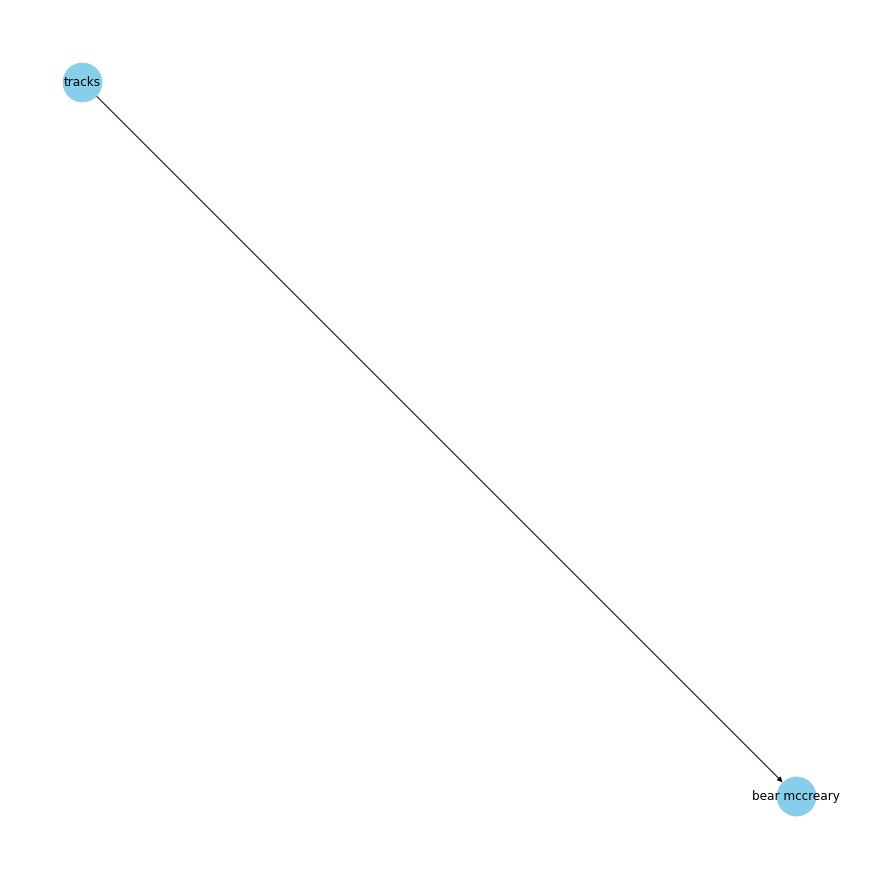

In [25]:
G=nx.from_pandas_edgelist(gc_df[gc_df['arista']=="written by"], "fuente", "objetivo", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

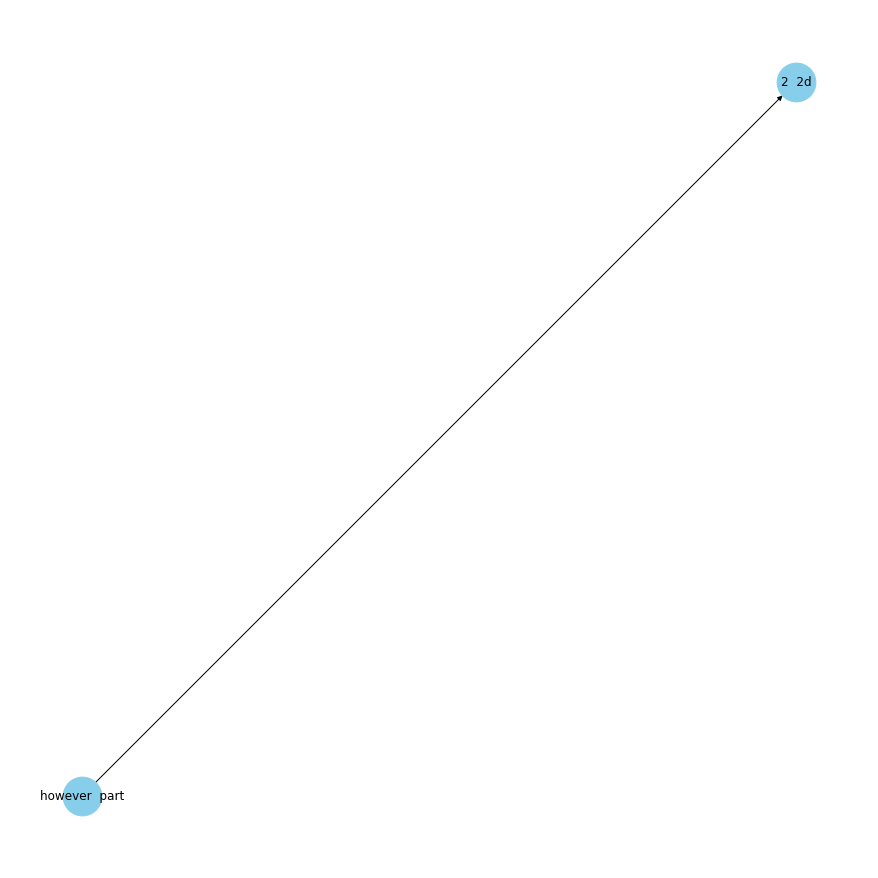

In [26]:
G=nx.from_pandas_edgelist(gc_df[gc_df['arista']=="released in"], "fuente", "objetivo", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

En este laboratorio, se revisó cómo extraer información de un texto dado en forma de triples (ontologías) y construir un gráfico de conocimiento a partir de él.

Sin embargo, nos limitamos a usar oraciones con exactamente 2 entidades. Incluso así pudimos construir gráficos de conocimiento bastante informativos. Consideren el potencial que tiene esto.

Se podría explorar más este campo de extracción de información para realizar la extracción de relaciones más complejas.

Su **práctica** es ahora realizar el mismo proceso de explorar un grafo de conocimiento con sus propias sentencias (en **español**, mínimo 10), desde un archivo CSV.

In [31]:
import spacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [32]:
nlp = spacy.load('es_core_news_sm') # para procesamiento de textos en español

In [33]:
sentencias_candidatas = pd.read_csv("Oraciones.csv",encoding = 'latin-1')
sentencias_candidatas.shape

(10, 1)

In [34]:
def get_entities(sent):
  ## Parte 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # etiqueta de dependencia del token anterior en la oración
  prv_tok_text = ""   # token anterior en la oración

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## Parte 2
    # Si el token es un signo de puntuación, pase al siguiente token
    if tok.dep_ != "punct":
      # comprobar: token es una palabra compuesta o no
      if tok.dep_ == "compound":
        prefix = tok.text
        # si la palabra anterior también era un 'compound', entonces agregar la palabra actual
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # comprobar: el token es un modificador o no
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # si la palabra anterior también era un 'compound', entonces agregar la palabra actual
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## Parte 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## Parte 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## Parte 5 
      # actualizar variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [36]:
get_entities("el mundial atrae personas")

['mundial', '']

In [38]:
pares_entidades = []

for i in tqdm(sentencias_candidatas["Oraciones"][0:200]): # con tqdm podemos mostrar una barra de progreso
  pares_entidades.append(get_entities(i))

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 141.65it/s]


In [40]:
pares_entidades[0:10]

[['mundial', ''],
 ['mundial', ''],
 ['España', ''],
 ['Ecuador', ''],
 ['mundial', ''],
 ['mundial', ''],
 ['mundial', ''],
 ['mundial', ''],
 ['mundial', ''],
 ['mundial', '']]

In [41]:
def get_relation(sent):

  doc = nlp(sent)

  # objeto de la clase Matcher
  matcher = Matcher(nlp.vocab)

  # definir el patrón 
  pattern = [[{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}]] 
    
  matcher.add("matching_1", pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [42]:
get_relation("el mundial genera dinero")

'genera'

In [43]:
relaciones = []
for i in tqdm(sentencias_candidatas["Oraciones"][0:200]): # con tqdm podemos mostrar una barra de progreso
  relaciones.append(get_relation(i))

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 127.69it/s]


In [44]:
pd.Series(relaciones).value_counts()[:20]

recaudo muchisimos    1
realizo               1
corono                1
clasifico             1
participaron          1
atrae                 1
comienza              1
espectaculo           1
tiene                 1
ultimo                1
dtype: int64

In [45]:
# extraer sujeto
fuente = [i[0] for i in pares_entidades]

# extraer objeto
objetivo = [i[1] for i in pares_entidades]

gc_df = pd.DataFrame({'fuente':fuente, 'objetivo':objetivo, 'arista':relaciones})

In [46]:
gc_df

,fuente,objetivo,arista
0,mundial,,recaudo muchisimos
1,mundial,,realizo
2,España,,corono
3,Ecuador,,clasifico
4,mundial,,participaron
5,mundial,,atrae
6,mundial,,comienza
7,mundial,,espectaculo
8,mundial,,tiene
9,mundial,,ultimo


In [47]:
# crear un grafo dirigido desde un dataframe
G=nx.from_pandas_edgelist(gc_df, "fuente", "objetivo", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

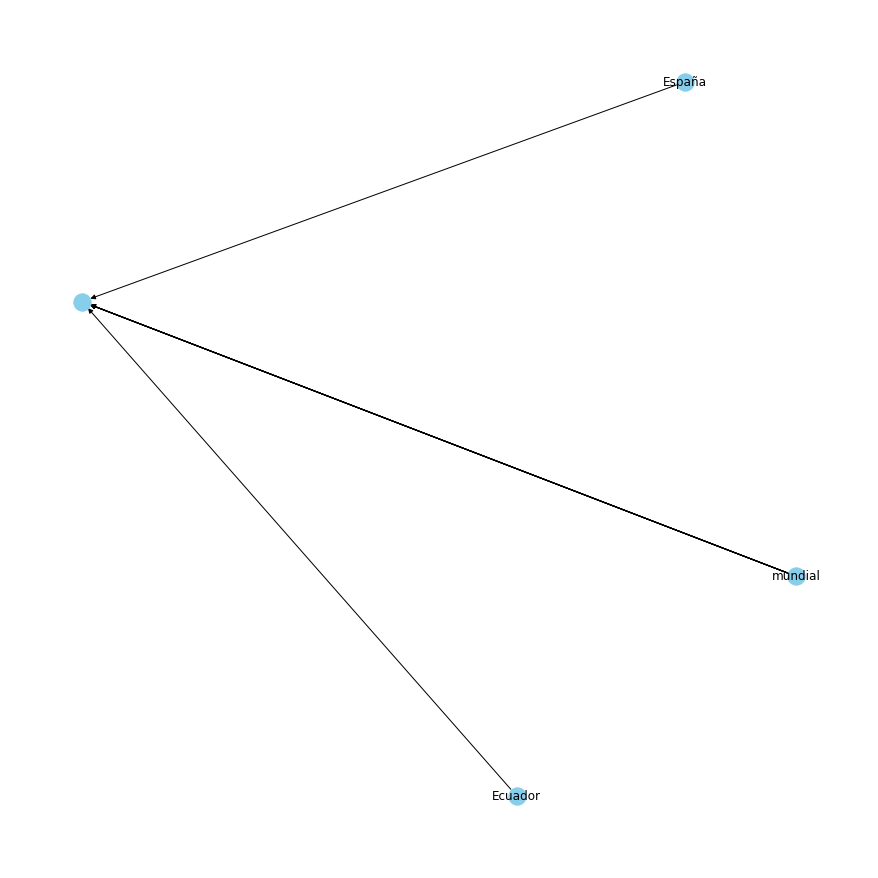

In [48]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

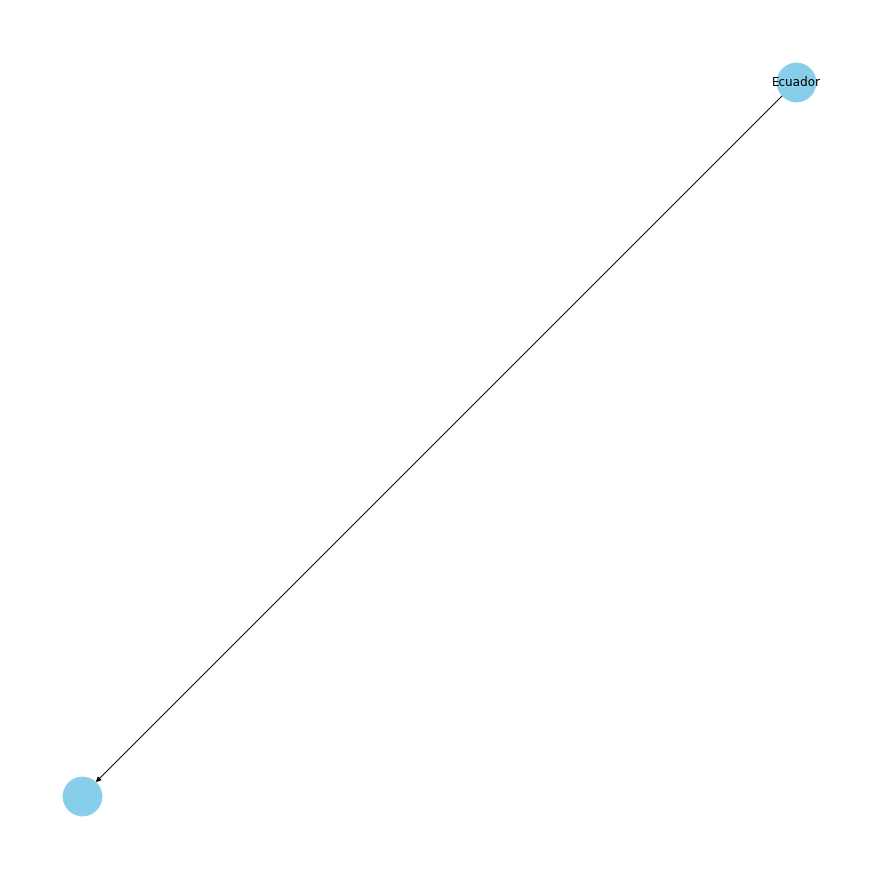

In [50]:
G=nx.from_pandas_edgelist(gc_df[gc_df['arista']=="clasifico"], "fuente", "objetivo", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regula la distancia entre nodos
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

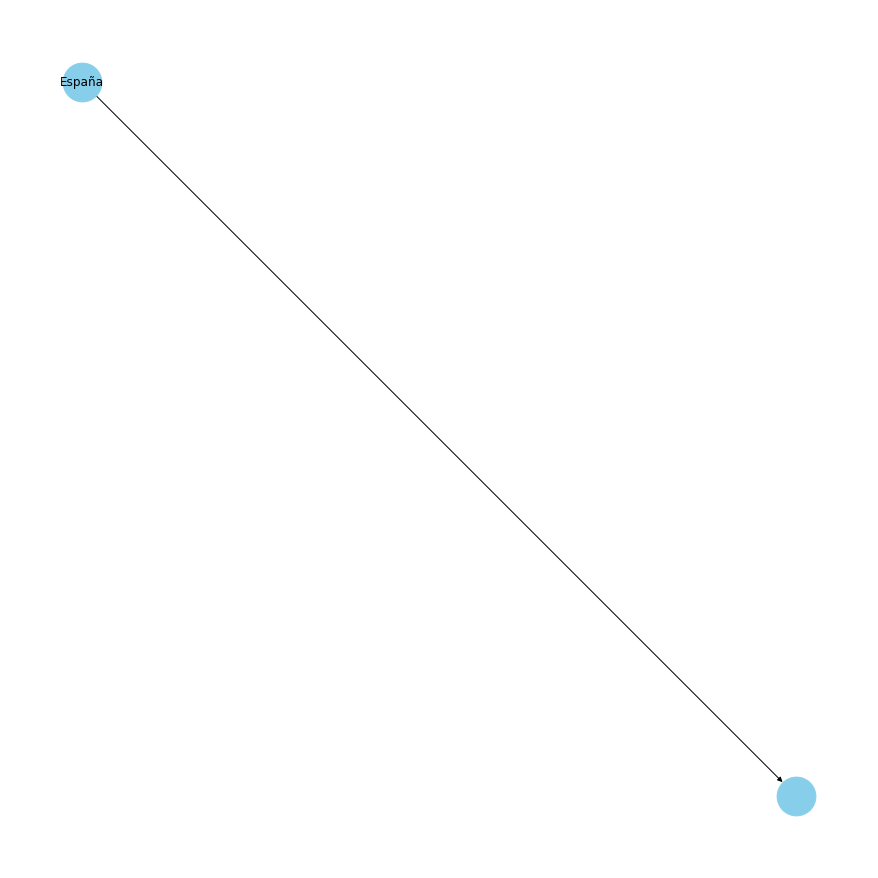

In [51]:
G=nx.from_pandas_edgelist(gc_df[gc_df['arista']=="corono"], "fuente", "objetivo", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

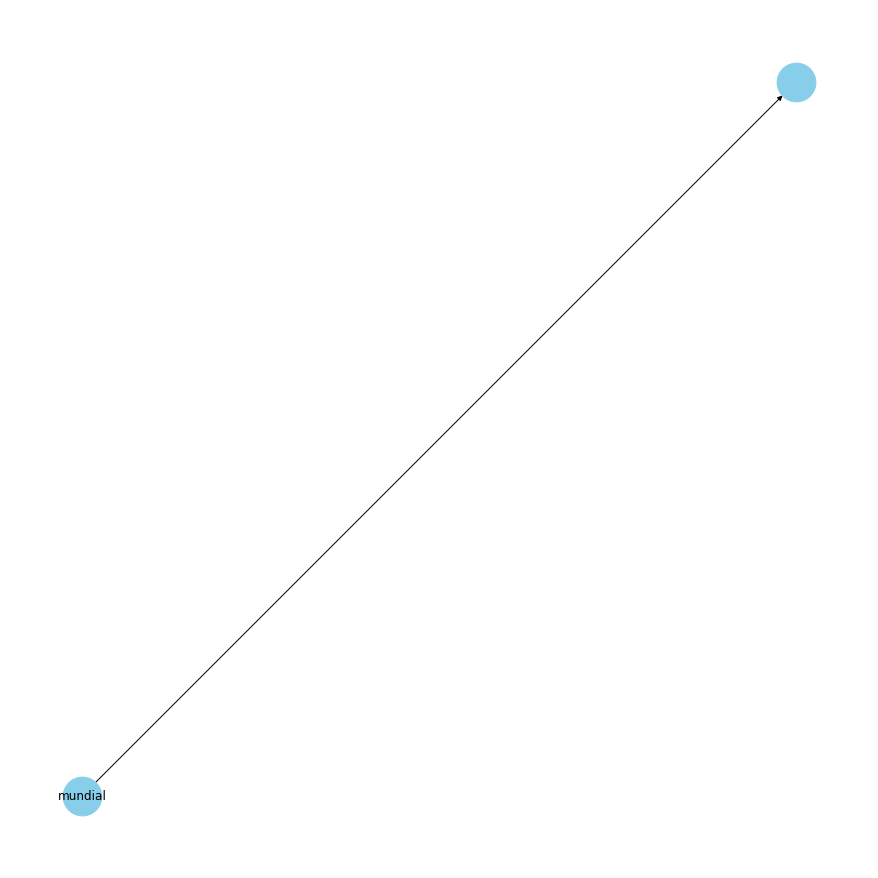

In [52]:
G=nx.from_pandas_edgelist(gc_df[gc_df['arista']=="comienza"], "fuente", "objetivo", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()